In [160]:
import json
import zipfile
import os
import sys
import io
from ast import literal_eval
import pandas as pd
from itertools import chain
from itertools import groupby
import unicodedata
import numpy as np
import collections

from string import punctuation
translator = str.maketrans('','',punctuation) 

In [161]:
class repository: 
    def __init__(self, policy, title, chapter, section, article):
        self.policy = policy
        self.title = title
        self.chapter = chapter
        self.section = section
        self.article = article
        
        
    def __repr__(self): #how to print the repository to the console
        return 'policy' + self.policy + ' title' + self.title + ' chapter' + self.chapter + ' section' + self.section + ' article' + self.article          
   
    @classmethod
    def from_repository_name(cls, rep_str):                #2nd initializer that creates a repository object directly from a repository string e.g 'EU_32008R1099_Title_0_Chapter_0_Section_0_Article_03.txt'
        folder_parts = rep_str.split('_')                  #split the string at '_' into parts 
        policy = folder_parts[0] + '_' + folder_parts[1]   #we only want to split at every 2nd '_', so merge the 1. and 2., 3. and 4. again 
        if folder_parts[2] in  ['front', 'Whereas']:       #exeption for the 'whereas' and 'front'
            title = 'front'
            chapter = 'None'
            section = 'None'
            article = 'None'
        else:
            title = folder_parts[2] + '_' + folder_parts[3]
            chapter = folder_parts[4] + '_' + folder_parts[5]
            section = folder_parts[6] + '_' + folder_parts[7]
            article = folder_parts[8] + '_' + folder_parts[9]
        
        return cls(policy,title, chapter, section, article)  #return a repository with the previously defined attributes
    
    def match(self, other):            #checks if the search-criteria defined in repository 'other' is matching the the current repository                                                
        self_value_set = set([x for x in list(self.__dict__.values()) if x != 'None']) #creates a set of all the attributes ignoring 'None'    
        other_value_set = set([x for x in list(other.__dict__.values()) if x != 'None'])
        

        return set(other_value_set).issubset(self_value_set) #returns True if the attributes of the search-criteria is a subset of the attributes of the current directory (=match)
    
class token:
    def __init__(self, start, stop, text):
        self.start = start
        self.stop = stop
        self.text = text
        
    def __repr__(self):
        return 'start' + self.start + ' stop' + self.stop + ' text' + self.text
        
    
class tag:
    def __init__(self, class_, type_, tag_, start, stop, text, tokens, rep):
        self.class_ = class_
        self.type_ = type_
        self.tag_ = tag_
        self.start = start
        self.stop = stop
        self.text = text
        self.tokens = tokens
        self.rep = rep
        
        
    def __eq__(self, other): 
        if not isinstance(other, tag):
            # don't attempt to compare against unrelated types
            return NotImplemented

        return self.class_ == other.class_ and self.type_ == other.type_ and self.tag_ == other.tag_ and self.start == other.start and self.stop == other.stop
    
    def __repr__(self): #for debugging purpose, defines how object is printed
        return "class:" + self.class_ + " type:" + self.type_ + " tag:" + self.tag_ + " start:" + str(self.start) + " stop:" + str(self.stop)

            
    
class Evaluator:
    
    def __init__(self, df):
        self.df = df
        
    def get_word_count(self, article):
        if article == 'None':
            return len(list(chain.from_iterable(self.df['tokens cleaned'])))
        
        if article in self.df['Policy'].tolist():
            return len(self.df.loc[self.df['Policy'] == article,'tokens cleaned'].iloc[0])
        
        else:
            raise Exception('This article is not present. Enter "None" to search all articles or a valid article')
    
        
        
    def _get_iterator_all(self): #returns a iterator of all the tags present in the dataframe
        
        return chain.from_iterable(self.df['Tags'])
        
        
    def _get_iterator_condition(self, conditional_rep): #returns a list for all the tags that match the attributes defined in the 'conditional_rep' 
  
        iterator = chain.from_iterable(self.df['Tags'])
        return [x for x in iterator if type(x)!= str and x.rep.match(conditional_rep) == True]
        
     
    
    def get_list_old(self, article, item, value):
        iterator = self._get_iterator(article)
        if item == 'class':
            return [x for x in iterator if type(x)!= str and x.class_ == value]
        if item == 'type':
            return [x for x in iterator if type(x)!= str and x.type_ == value]
        if item == 'tag':
            return [x for x in iterator if type(x)!= str and x.tag_ == value]
        
    def get_tag_list(self, conditional_rep, item, value):
       
        iterator = self._get_iterator_condition(conditional_rep)
        
        if item == 'None' and value == 'None':
            return [x for x in iterator if type(x)!= str ]
        if item == 'class':
            return [x for x in iterator if type(x)!= str and x.class_ == value]
        if item == 'type':
            return [x for x in iterator if type(x)!= str and x.type_ == value]
        if item == 'tag':
            return [x for x in iterator if type(x)!= str and x.tag_ == value]
        
    
    def get_span_distro(self, conditional_rep, item, value, return_format):
        
        tag_list = self.get_tag_list(conditional_rep, item, value)
        len_list = [(x.stop - x.start) for x in tag_list]
        len_dict = collections.Counter(len_list)
        
        if return_format == 'dict':
            return dict(sorted(len_dict.items(), key=lambda item: item[1], reverse=True))
            
        
        if return_format == 'list':
            distro_list = []
            for i in range(1,max(len_list)+1):
                distro_list.append(len_list.count(i))
            return distro_list
                      
     
    def get_frequency(self, article, item, value):
        return len(self.get_list(article, item, value))
    
    def most_frequent_tokens(self, conditional_rep, item, value,):
        tag_list = self.get_tag_list(conditional_rep, item, value)
        

        
        
        return 0

            
         
        
        
        
    
      
  
          
        

In [162]:
def normalize_and_replace_text(sentence):
    doc = unicodedata.normalize("NFKD", sentence)
    doc = doc.replace('\r', '').replace('\n', ' ')

    
    return doc

def clean_text(doc):
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    no_numbers = [w if not w.isdigit() else '#' for w in words]

    return no_numbers

def get_repository_names(folder_name):
    folder_parts = folder_name.split('_')
    policy = folder_parts[0] + '_' + folder_parts[1]
    title = folder_parts[2] + '_' + folder_parts[3]
    chapter = folder_parts[4] + '_' + folder_parts[5]
    section = folder_parts[6] + '_' + folder_parts[7]
    article = folder_parts[8] + '_' + folder_parts[9]
    
    
     
    return policy, title, chapter, section, article



In [163]:
stat_df = pd.DataFrame(columns = ['Policy', 'Text','Tags']) #create the initial dataframe
tagsets = ['Policydesigncharacteristics','Technologyandapplicationspecificity','Instrumenttypes']


In [164]:
path = '/home/kueddelmaier/Downloads/full_project_curated_json/curation'  #Datapath
subdirs = [o for o in os.listdir(path) if os.path.isdir(path)] #identify all the subdirs which correspond to different articles
os.chdir(path)

In [165]:
for subdir in subdirs:
   
    try:
        archive = zipfile.ZipFile(os.path.join(subdir, str(os.listdir(subdir)[0])), 'r') #decode compressed json in zip file
        json_file_byte = archive.read('CURATION_USER.json')      #this is a binary
        
        json_file_byte_decode = json_file_byte.decode('utf8')    #decode to json
    
        data = json.loads(json_file_byte_decode)
    
    except:
        stat_df = stat_df.append(pd.Series([subdir, 'error', 'error'], index=stat_df.columns ), ignore_index=True) #append error column if cannot read data

        
    else:
        taglist = []      #create epty list holding all the tags of the aragraph (= article)
        rep = repository.from_repository_name(subdir[0:-4])  #directory name in string format
        sentence = data['_referenced_fss']['1']['sofaString']  #raw text of the paragraph
        all_tokens = data['_views']['_InitialView']['Token']
        all_tokens[0]['begin'] = 0                            #the first token is missing the beginning
        sentence_normalized = normalize_and_replace_text(sentence) 
        
        for category in data['_views']['_InitialView']:  #loop trough the custom layers
  
            if category in tagsets:
                    
                for annotation in data['_views']['_InitialView'][category]: #loop trough all the tags
                    
                    type_ = list(annotation.keys())[-1]     #this part handles empty annotations. The last entry of the dict usually contains the type and the tag.
                                                            #for empty tags, the last entry is a integer
                    if type(type_) != str:                  
                        type_ = ''
                    tag_ = list(annotation.values())[-1]
                    if type(tag_) != str:
                        tag_ = ''
                        
                    start = annotation['begin']
                    stop = annotation['end']
                    tokens = [token(x['begin'], x['end'], sentence[x['begin']:x['end']]) for x in all_tokens if  x['begin'] >= start and x['end'] <= stop]
                    taglist.append(tag(category, type_, tag_ , start ,stop , sentence[start:stop], tokens, rep))
                    
        stat_df = stat_df.append(pd.Series([subdir[0:-4], sentence ,taglist], index=stat_df.columns ), ignore_index=True)     
stat_df['tokens cleaned'] = stat_df['Text'].apply(clean_text)    

In [170]:
test_eval = Evaluator(stat_df)
test_dir = repository('EU_32008R1099', 'None', 'None', 'None', 'None')
test_eval.get_tag_list(test_dir, 'tag', 'Addressee_monitored')




[class:Policydesigncharacteristics type:Actor tag:Addressee_monitored start:48 stop:61,
 class:Policydesigncharacteristics type:Actor tag:Addressee_monitored start:528 stop:540,
 class:Policydesigncharacteristics type:Actor tag:Addressee_monitored start:48 stop:61,
 class:Policydesigncharacteristics type:Actor tag:Addressee_monitored start:1676 stop:1689,
 class:Policydesigncharacteristics type:Actor tag:Addressee_monitored start:1997 stop:2010,
 class:Policydesigncharacteristics type:Actor tag:Addressee_monitored start:41 stop:54,
 class:Policydesigncharacteristics type:Actor tag:Addressee_monitored start:145 stop:158,
 class:Policydesigncharacteristics type:Actor tag:Addressee_monitored start:233 stop:242]

In [166]:
type(stat_df['Tags'][2][2].text)

str

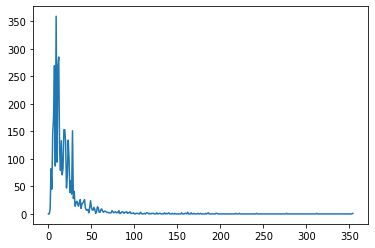

In [167]:
import matplotlib.pyplot as plt
plt.plot(test_eval.get_span_distro(hello,'None', 'None', 'list'))
plt.show()


In [10]:
test_eval.get_span_distro(hello,'class', 'Instrumenttypes', 'list')

ValueError: max() arg is an empty sequence

In [11]:
test_eval.most_frequent_spans(hello,'tag', 'Tech_Other')

AttributeError: 'Evaluator' object has no attribute 'most_frequent_spans'

In [53]:
testdir = repository('EU_32008R1099', 'None', 'None', 'None', 'Article_06.txt')
test_eval = Evaluator(stat_df)
test_l = test_eval.get_tag_list(hello,'None', 'None')


In [36]:
 test = "Article 6\r\nQuality assessment and reports\r\n1.   Member States shall ensure the quality of the data transmitted.\r\n2.   Every reasonable effort shall be undertaken to ensure coherence between energy data declared in accordance with Annex B and data declared in accordance with Commission Decision 2005/166/EC of 10 February 2005 laying down the rules for implementing Decision No 280/2004/EC of the European Parliament and of the Council concerning a mechanism for monitoring Community greenhouse gas emissions and for implementing the Kyoto Protocol (12).\r\n3.   For the purposes of this Regulation, the following quality assessment dimensions shall apply to the data to be transmitted:\r\n(a)\r\n‘relevance’ shall refer to the degree to which statistics meet current and potential needs of the users;\r\n(b)\r\n‘accuracy’ shall refer to the closeness of estimates to the unknown true values;\r\n(c)\r\n‘timeliness’ shall refer to the delay between the availability of the information and the event or phenomenon it describes;\r\n(d)\r\n‘punctuality’ shall refer to the delay between the date of the release of the data and the target date when it should have been delivered;\r\n(e)\r\n‘accessibility’ and ‘clarity’ shall refer to the conditions and modalities by which users can obtain, use and interpret data;\r\n(f)\r\n‘comparability’ shall refer to the measurement of the impact of differences in applied statistical concepts and measurement tools and procedures where statistics are compared between geographical areas, sectoral domains or over time;\r\n(g)\r\n‘coherence’ shall refer to the adequacy of the data to be reliably combined in different ways and for various uses.\r\n4.   Every five years, Member States shall provide the Commission (Eurostat) with a report on the quality of the data transmitted as well as on any methodological changes that have been made.\r\n5.   Within six months of receipt of a request from the Commission (Eurostat), and in order to allow it to assess the quality of the data transmitted, Member States shall send to the Commission (Eurostat) a report containing any relevant information concerning the implementation of this Regulation.\r\n"

In [43]:
test[343:348]

'rules'

In [26]:
search_dir = repository('None', 'None', 'None', 'section1', 'article1')
testdir_else = repository('None', 'None', 'chapter1', 'section1', 'article1')
search_dir_list = list(search_dir.__dict__.values())
testdir_else_list = list(testdir_else.__dict__.values())
print(search_dir_list)
print(testdir_else_list)
#print([x for x in search_dir_list if x in testdir_else_list and x  != 'None'])
set([x for x in search_dir_list if x != 'None']).issubset(set(testdir_else_list)) 
        
        

['None', 'None', 'None', 'section1', 'article1']
['None', 'None', 'chapter1', 'section1', 'article1']


True

In [437]:
list(test_dir.__dict__.values())

NameError: name 'test_dir' is not defined

In [21]:
stat_df.loc[stat_df['Policy'] == 'EU_32019R0631_Title_0_Chapter_0_Section_0_Article_16.','Tags'].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [31]:
text = stat_df.loc[stat_df['Policy'] == 'EU_32008R1099_Title_0_Chapter_0_Section_0_Article_06','Text'].iloc[0]

In [35]:
text[832:841]

's of esti'

In [94]:
subset = stat_df['Tags'][0:2]
for set_ in subset:
    for entry in set_:
        print(entry.class_)




Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity
Technologyandapplicationspecificity


In [97]:
[x for b in subset for x in b if x.class_ == 'Technologyandapplicationspecificity'] 

In [110]:
stat_df['']

NameError: name '__main__' is not defined

In [51]:
len([x for x in chain.from_iterable(stat_df['Tags']) if type(x)!= str and x.class_ == 'Technologyandapplicationspecificity']) 

1344

In [20]:
list_ = []
for element in data['_views']['_InitialView']['Token']:
    
    
    

[{'sofa': 1, 'end': 7},
 {'sofa': 1, 'begin': 7, 'end': 8},
 {'sofa': 1, 'begin': 8, 'end': 9},
 {'sofa': 1, 'begin': 11, 'end': 16},
 {'sofa': 1, 'begin': 17, 'end': 25},
 {'sofa': 1, 'begin': 26, 'end': 33},
 {'sofa': 1, 'begin': 34, 'end': 40},
 {'sofa': 1, 'begin': 41, 'end': 47},
 {'sofa': 1, 'begin': 49, 'end': 50},
 {'sofa': 1, 'begin': 50, 'end': 51},
 {'sofa': 1, 'begin': 51, 'end': 54},
 {'sofa': 1, 'begin': 54, 'end': 57},
 {'sofa': 1, 'begin': 58, 'end': 60},
 {'sofa': 1, 'begin': 61, 'end': 65},
 {'sofa': 1, 'begin': 66, 'end': 72},
 {'sofa': 1, 'begin': 73, 'end': 79},
 {'sofa': 1, 'begin': 80, 'end': 83},
 {'sofa': 1, 'begin': 84, 'end': 93},
 {'sofa': 1, 'begin': 94, 'end': 96},
 {'sofa': 1, 'begin': 97, 'end': 100},
 {'sofa': 1, 'begin': 101, 'end': 106},
 {'sofa': 1, 'begin': 107, 'end': 109},
 {'sofa': 1, 'begin': 110, 'end': 115},
 {'sofa': 1, 'begin': 116, 'end': 124},
 {'sofa': 1, 'begin': 125, 'end': 133},
 {'sofa': 1, 'begin': 134, 'end': 136},
 {'sofa': 1, 'beg

In [23]:
[x['begin'] for x in  data['_views']['_InitialView']['Token']]

KeyError: 'begin'

In [21]:
[x['begin'] for x in  data['_views']['_InitialView']['Token'] if int(x['begin']) < 50]

KeyError: 'begin'

In [72]:
list(data['_views']['_InitialView']['Technologyandapplicationspecificity'][0].values())

[1, 57, 88, 'Tech_LowCarbon']

In [74]:
test_df = pd.DataFrame(columns = ['text'], index = np.arange(0,2))
test_df['text'].loc[0] = 'hello peter ist mee'
test_df['text'].loc[1] = 'why I am su sotun'

In [75]:
test_df.head()

,text
0,hello peter ist mee
1,why I am su sotun


In [81]:
test_df['text'] = test_df['text'].apply(clean_text)

In [85]:

len(list(chain.from_iterable(test_df['text'])))

9

In [38]:
class Negator(object):
    def __eq__(self,other):
        return not other

thing = Negator()
print(thing == None)    #True
print(thing is None)    #False

True
False


In [199]:
hello = 1 if 1 < 2

SyntaxError: invalid syntax (<ipython-input-199-833455e983d3>, line 1)

In [75]:
all_tokens = data['_views']['_InitialView']['Token']

In [76]:
all_tokens

[{'sofa': 1, 'end': 7, 'begin': 0},
 {'sofa': 1, 'begin': 7, 'end': 8},
 {'sofa': 1, 'begin': 8, 'end': 10},
 {'sofa': 1, 'begin': 12, 'end': 21},
 {'sofa': 1, 'begin': 22, 'end': 24},
 {'sofa': 1, 'begin': 25, 'end': 28},
 {'sofa': 1, 'begin': 29, 'end': 35},
 {'sofa': 1, 'begin': 36, 'end': 42},
 {'sofa': 1, 'begin': 44, 'end': 45},
 {'sofa': 1, 'begin': 45, 'end': 46},
 {'sofa': 1, 'begin': 46, 'end': 49},
 {'sofa': 1, 'begin': 49, 'end': 53},
 {'sofa': 1, 'begin': 54, 'end': 60},
 {'sofa': 1, 'begin': 61, 'end': 66},
 {'sofa': 1, 'begin': 67, 'end': 72},
 {'sofa': 1, 'begin': 73, 'end': 79},
 {'sofa': 1, 'begin': 80, 'end': 81},
 {'sofa': 1, 'begin': 82, 'end': 88},
 {'sofa': 1, 'begin': 89, 'end': 91},
 {'sofa': 1, 'begin': 92, 'end': 95},
 {'sofa': 1, 'begin': 96, 'end': 106},
 {'sofa': 1, 'begin': 107, 'end': 109},
 {'sofa': 1, 'begin': 110, 'end': 118},
 {'sofa': 1, 'begin': 119, 'end': 121},
 {'sofa': 1, 'begin': 122, 'end': 125},
 {'sofa': 1, 'begin': 126, 'end': 135},
 {'sof

In [77]:
all_tokens[0]['begin'] = 0
start = 34
end = 47

In [78]:
[x for x in all_tokens if  x['begin'] >= start and x['end'] <= end]

[{'sofa': 1, 'begin': 36, 'end': 42},
 {'sofa': 1, 'begin': 44, 'end': 45},
 {'sofa': 1, 'begin': 45, 'end': 46}]

In [80]:
ls = [token(x['begin'], x['end'], data['_referenced_fss']['1']['sofaString'][x['begin']:x['end']]) for x in all_tokens if  x['begin'] >= start and x['end'] <= end]

In [86]:
ls[2].text

'.'

In [44]:
[x for x in all_tokens if x['begin'] > 34]

    

[{'sofa': 1, 'begin': 41, 'end': 47},
 {'sofa': 1, 'begin': 49, 'end': 50},
 {'sofa': 1, 'begin': 50, 'end': 51}]

In [57]:
data['_referenced_fss']['1']['sofaString'][34:47]

'Member States\r'

In [51]:
data['_views']['_InitialView']['Policydesigncharacteristics']

[{'sofa': 1, 'begin': 34, 'end': 47, 'Actor': 'Addressee_default'},
 {'sofa': 1, 'begin': 66, 'end': 79, 'Actor': 'Addressee_default'},
 {'sofa': 1, 'begin': 247, 'end': 264, 'Actor': 'Addressee_sector'},
 {'sofa': 1, 'begin': 272, 'end': 285, 'Actor': 'Addressee_monitored'},
 {'sofa': 1, 'begin': 303, 'end': 313, 'Actor': 'Authority_monitoring'},
 {'sofa': 1, 'begin': 345, 'end': 658, 'Resource': 'Resource_Other'},
 {'sofa': 1, 'begin': 635, 'end': 658, 'Objective': 'Objective_QualIntention'},
 {'sofa': 1, 'begin': 670, 'end': 682, 'Actor': 'Addressee_resource'},
 {'sofa': 1, 'begin': 703, 'end': 723, 'Compliance': 'Form_monitoring'},
 {'sofa': 1, 'begin': 828, 'end': 903, 'Compliance': 'Form_monitoring'},
 {'sofa': 1, 'begin': 911, 'end': 1107, 'Compliance': 'Form_monitoring'},
 {'sofa': 1, 'begin': 911, 'end': 1011, 'Compliance': 'Form_monitoring'},
 {'sofa': 1, 'begin': 947, 'end': 1083, 'Resource': 'Resource_Other'},
 {'sofa': 1,
  'begin': 1060,
  'end': 1083,
  'Objective': 'Obj

In [58]:
text = 'hello'
text[:2]

'he'

In [61]:
token

{'sofa': 1, 'begin': 8, 'end': 9}

__main__.token